In [1]:
#!conda install -c conda-forge bayesian-optimization

In [2]:
from bayes_opt import BayesianOptimization
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D



In [3]:
## https://bayesian-optimization.github.io/BayesianOptimization/basic-tour.html

def black_box_function(x, y):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """
    #return -x ** 2 - (y - 1) ** 2 + 1
    return np.sin(x) + np.sin(y)

In [4]:
# Bounded region of parameter space
pbounds = {'x': (-10, 10), 'y': (-10, 10)}

In [5]:
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

In [15]:
optimizer.maximize(
    init_points=10, # How many steps of random exploration you want to perform. (diversifying the exploration space)
    n_iter=20, # How many steps of bayesian optimization you want to perform. 
                # It looks like 20 doesn't do a very good job, but you can run it again and again and get more
    # The total number of points is init_points + n_iter
)

# If verbose = 2, then the best ones show up in purple, marking the conclusion of an iteration

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 21        | -0.2056   | 6.015     | 9.365     |
| 22        | -0.09163  | -3.732    | 3.846     |
| 23        | 1.947     | 7.528     | 7.892     |
| 24        | -1.107    | -8.299    | -9.219    |
| 25        | 0.6432    | -6.603    | 7.563     |
| 26        | -1.984    | -8.033    | -1.578    |
| 27        | 0.8796    | 9.158     | 0.6633    |
| 28        | -0.1201   | 3.838     | -3.69     |
| 29        | -0.1571   | 3.73      | 6.693     |
| 30        | -0.7502   | -9.634    | 5.003     |
| 31        | 1.153     | 7.737     | 6.444     |
| 32        | 1.605     | 8.732     | 7.591     |
| 33        | -0.6874   | 10.0      | 3.285     |
| 34        | -0.9616   | 9.398     | -1.721    |
| 35        | 1.654     | 7.04      | 1.315     |
| 36        | 0.01426   | 5.915     | 2.758     |
| 37        | 0.368     | 6.754     | -0.08549  |
| 38        | 1.938     | 8.016     | 1.886     |


In [16]:
print(optimizer.max)

{'target': 1.9465396407093518, 'params': {'x': 7.527783045920767, 'y': 7.892133270076947}}


In [17]:
xbest = optimizer.max['params']['x']
ybest = optimizer.max['params']['y']

In [18]:
# Define the range for x and y
x = np.linspace(pbounds['x'][0], pbounds['x'][1], 100)
y = np.linspace(pbounds['y'][0], pbounds['x'][1], 100)
xgrid, ygrid = np.meshgrid(x, y, sparse = True)
z = black_box_function(xgrid, ygrid) # Let's see what this really looks like. (This might be slow!)

#zbest = black_box_function(xbest, ybest)

In [19]:
xtested = [res['params']['x'] for res in optimizer.res]
ytested = [res['params']['y'] for res in optimizer.res]

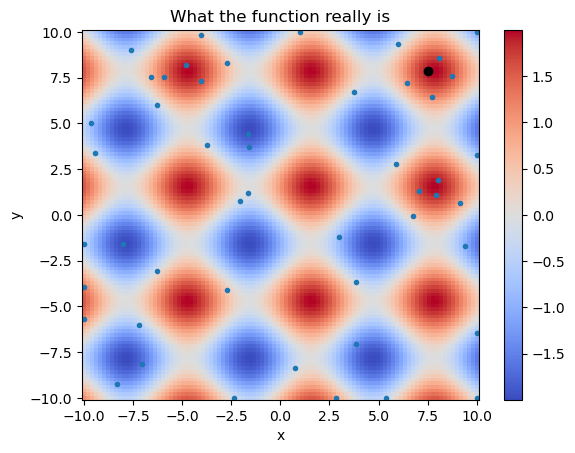

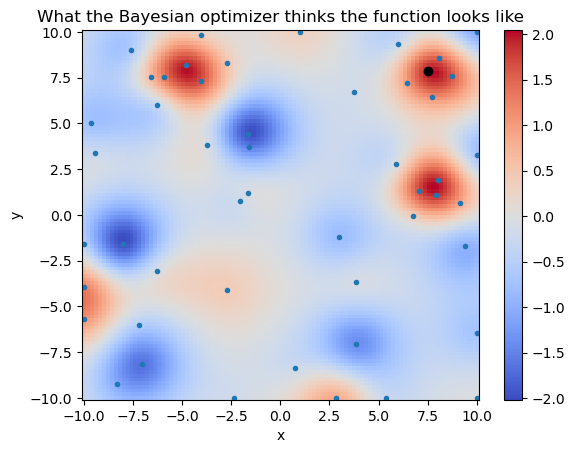

In [20]:
plt.figure()
plt.pcolormesh(xgrid, ygrid, z,  cmap=plt.cm.coolwarm, alpha=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()  # Add a color bar which maps values to colors
plt.title('What the function really is');
plt.plot(xtested, ytested, '.') # plot tested points
plt.plot(xbest, ybest, 'ko') # plot the best point

xy = np.array([[x_i, y_j] for y_j in y for x_i in x])
Z_est = optimizer._gp.predict(xy).reshape(z.shape)
plt.figure()
plt.pcolormesh(xgrid, ygrid, Z_est,  cmap=plt.cm.coolwarm, alpha=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()  # Add a color bar which maps values to colors
plt.title('What the Bayesian optimizer thinks the function looks like');
plt.plot(xtested, ytested, '.') # plot tested points
plt.plot(xbest, ybest, 'ko'); # plot the best point

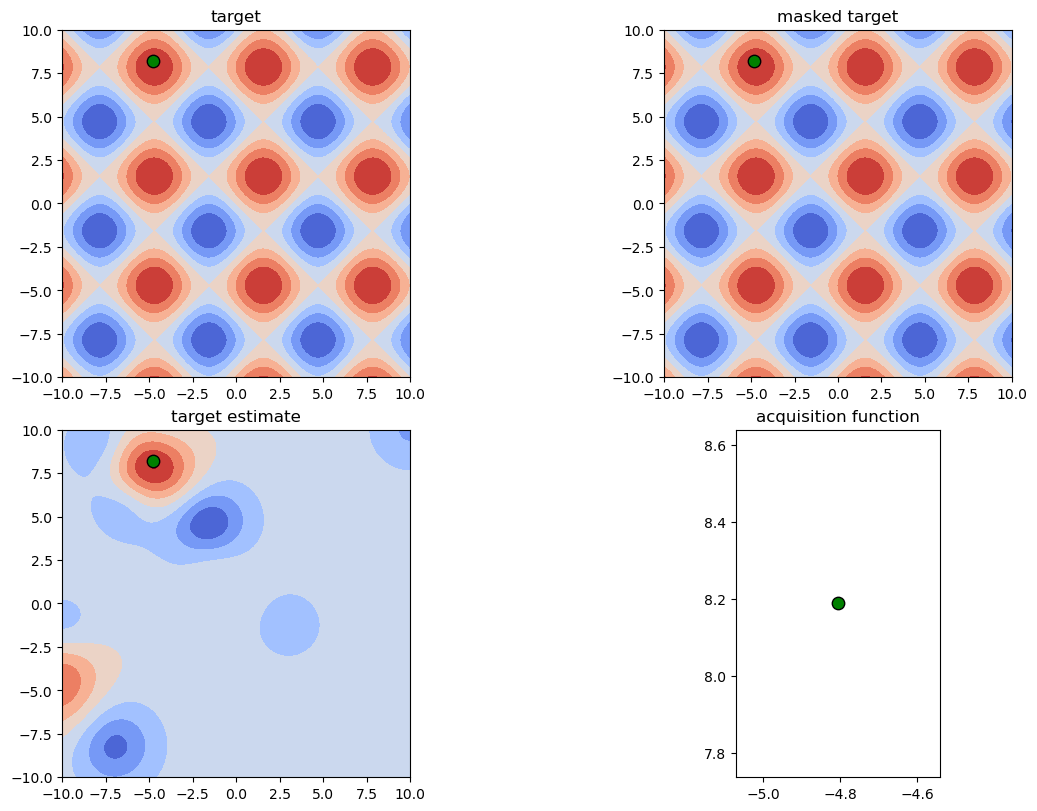

In [12]:
# Plotting function from 
# https://bayesian-optimization.github.io/BayesianOptimization/constraints.html#2.-Advanced-Constrained-Optimization

def plot_constrained_opt(pbounds, target_function, optimizer):
    """
    Plots a number of interesting contours to visualize constrained 2-dimensional optimization.
    """

    # Set a few parameters
    try:
        n_constraints = optimizer.constraint.lb.size
    except:
        n_constraints = 0
    n_plots_per_row = 2+n_constraints

    # Construct the subplot titles
    if n_constraints==1:
        c_labels = ["constraint"]
    else:
        c_labels = [f"constraint {i+1}" for i in range(n_constraints)]
    labels_top = ["target"] + c_labels + ["masked target"]
    labels_bot = ["target estimate"] + [c + " estimate" for c in c_labels] + ["acquisition function"]
    labels = [labels_top, labels_bot]

    # Setup the grid to plot on
    x = np.linspace(pbounds['x'][0], pbounds['x'][1], 1000)
    y = np.linspace(pbounds['y'][0], pbounds['y'][1], 1000)
    xy = np.array([[x_i, y_j] for y_j in y for x_i in x])
    X, Y = np.meshgrid(x, y)

    # Evaluate the actual functions on the grid
    Z = target_function(X, Y)

    try:
        # This reshaping is a bit painful admittedly, but it's a consequence of np.meshgrid
        C = optimizer.constraint.fun(X, Y).reshape((n_constraints,) + Z.shape).swapaxes(0, -1)
    except:
        pass


    fig, axs = plt.subplots(2, n_plots_per_row, constrained_layout=True, figsize=(12,8))

    for i in range(2):
        for j in range(n_plots_per_row):
            axs[i, j].set_aspect("equal")
            axs[i, j].set_title(labels[i][j])


    # Extract & unpack the optimization results
    max_ = optimizer.max
    res = optimizer.res
    x_ = np.array([r["params"]['x'] for r in res])
    y_ = np.array([r["params"]['y'] for r in res])
    try:
        c_ = np.array([r["constraint"] for r in res])
    except:
        pass
    try:
        a_ = np.array([r["allowed"] for r in res])
    except:
        pass


    Z_est = optimizer._gp.predict(xy).reshape(Z.shape)
    try:
        C_est = optimizer.constraint.approx(xy).reshape(Z.shape + (n_constraints,))
    except:
        pass
    try:
        P_allowed = optimizer.constraint.predict(xy).reshape(Z.shape)
        Acq = np.where(Z_est >0, Z_est * P_allowed, Z_est / (0.5 + P_allowed))
        constraint_vbounds = np.min([C, C_est]), np.max([C, C_est])
    except:
        pass



    target_vbounds = np.min([Z, Z_est]), np.max([Z, Z_est])

    axs[0,0].contourf(X, Y, Z, cmap=plt.cm.coolwarm, vmin=target_vbounds[0], vmax=target_vbounds[1])
    for i in range(n_constraints):
        axs[0,1+i].contourf(X, Y, C[:,:,i], cmap=plt.cm.coolwarm, vmin=constraint_vbounds[0], vmax=constraint_vbounds[1])
    Z_mask = Z

    try:
        Z_mask[~np.squeeze(optimizer.constraint.allowed(C))] = np.nan
    except:
        pass
    axs[0,n_plots_per_row-1].contourf(X, Y, Z_mask, cmap=plt.cm.coolwarm, vmin=target_vbounds[0], vmax=target_vbounds[1])

    axs[1,0].contourf(X, Y, Z_est, cmap=plt.cm.coolwarm, vmin=target_vbounds[0], vmax=target_vbounds[1])
    for i in range(n_constraints):
        axs[1,1+i].contourf(X, Y, C_est[:, :, i], cmap=plt.cm.coolwarm, vmin=constraint_vbounds[0], vmax=constraint_vbounds[1])
    try:
        axs[1,n_plots_per_row-1].contourf(X, Y, Acq, cmap=plt.cm.coolwarm, vmin=0, vmax=1)
    except:
        pass

    for i in range(2):
        for j in range(n_plots_per_row):
            if 'a_' in dir():
                axs[i,j].scatter(x_[a_], y_[a_], c='white', s=80, edgecolors='black')
                axs[i,j].scatter(x_[~a_], y_[~a_], c='red', s=80, edgecolors='black')
            axs[i,j].scatter(max_["params"]['x'], max_["params"]['y'], s=80, c='green', edgecolors='black')

    return fig, axs

plot_constrained_opt(pbounds = pbounds, target_function = black_box_function, optimizer = optimizer);